In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
!pip install cartopy rasterio rasterstats -q

In [ ]:
import ee
import geopandas as gpd
import pandas as pd
import geopandas as gpd
import numpy as np
import time
from rasterstats import zonal_stats
import rasterio
from osgeo import gdal
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from concurrent.futures import ThreadPoolExecutor



In [ ]:
base_folder = '/content/drive/MyDrive/hwi_product'
output_folder = '/content/drive/MyDrive/hwi_stats/dgca_back'

In [ ]:
##getting average HWI

In [ ]:
# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Initialize a dictionary to store annual global means
global_means = {
    'year': [],
    'hw_count_mean': [],
    'hw_days_mean': [],
    'hw_temp_diff_mean': [],
    'high_temp_degree_days_mean': []
}

# Iterate through the years with corresponding service accounts
for index, start_year in enumerate(range(1960, 2024, 10), start=1):
    print(f"Index: {index}, Year: {start_year}")
    vrt_file = os.path.join(base_folder, f'hwi_{start_year}s/temp.vrt')

    if os.path.exists(vrt_file):
        with rasterio.open(vrt_file) as src:
            num_years = (src.count - 1) // 4  # Each year has 4 bands for variables
            print(f"Number of years in this decade: {num_years}")

            # Initialize arrays to store sums for each variable
            hw_count_sum = None
            hw_days_sum = None
            hw_temp_diff_sum = None
            high_temp_degree_days_sum = None

            for year in range(int(num_years)):
                band_start = 2 + year * 4  # Skip the land mask band

                # Read each variable for the year
                hw_count = src.read(band_start)
                hw_days = src.read(band_start + 1)
                hw_temp_diff = src.read(band_start + 2)
                high_temp_degree_days = src.read(band_start + 3)

                # Initialize sum arrays if they are None
                if hw_count_sum is None:
                    hw_count_sum = np.zeros_like(hw_count, dtype='float32')
                    hw_days_sum = np.zeros_like(hw_days, dtype='float32')
                    hw_temp_diff_sum = np.zeros_like(hw_temp_diff, dtype='float32')
                    high_temp_degree_days_sum = np.zeros_like(high_temp_degree_days, dtype='float32')

                # Accumulate the sums
                hw_count_sum += hw_count
                hw_days_sum += hw_days
                hw_temp_diff_sum += hw_temp_diff
                high_temp_degree_days_sum += high_temp_degree_days

                # Calculate annual global means
                hw_count_mean = np.nanmean(hw_count)
                hw_days_mean = np.nanmean(hw_days)
                hw_temp_diff_mean = np.nanmean(hw_temp_diff)
                high_temp_degree_days_mean = np.nanmean(high_temp_degree_days)

                # Append to global means dictionary
                global_means['year'].append(start_year + year)
                global_means['hw_count_mean'].append(hw_count_mean)
                global_means['hw_days_mean'].append(hw_days_mean)
                global_means['hw_temp_diff_mean'].append(hw_temp_diff_mean)
                global_means['high_temp_degree_days_mean'].append(high_temp_degree_days_mean)

            # Calculate the average for each variable
            hw_count_avg = hw_count_sum / num_years
            hw_days_avg = hw_days_sum / num_years
            hw_temp_diff_avg = hw_temp_diff_sum / num_years
            high_temp_degree_days_avg = high_temp_degree_days_sum / num_years

            # Define the metadata for the new raster file
            meta = {
                'driver': 'GTiff',
                'height': src.height,
                'width': src.width,
                'count': 4,
                'dtype': 'float32',
                'crs': src.crs,
                'transform': src.transform
            }

            # Save the average data to a new file
            output_file = os.path.join(output_folder, f'average_hwi_{start_year}s.tif')
            with rasterio.open(output_file, 'w', **meta) as dst:
                dst.write(hw_count_avg, 1)
                dst.write(hw_days_avg, 2)
                dst.write(hw_temp_diff_avg, 3)
                dst.write(high_temp_degree_days_avg, 4)

            print(f"Saved average temperature variables for {start_year}s to {output_file}")

# Save the global means to a CSV file
csv_output_file = os.path.join(output_folder, 'annual_global_means.csv')
df = pd.DataFrame(global_means)
df.to_csv(csv_output_file, index=False)

print(f"Saved annual global means to {csv_output_file}")


In [ ]:
#plot decadal change

<ipython-input-9-32f7bdd301bc>:29: RuntimeWarning: invalid value encountered in divide
  hw_avg_days = hw_days/hw_count


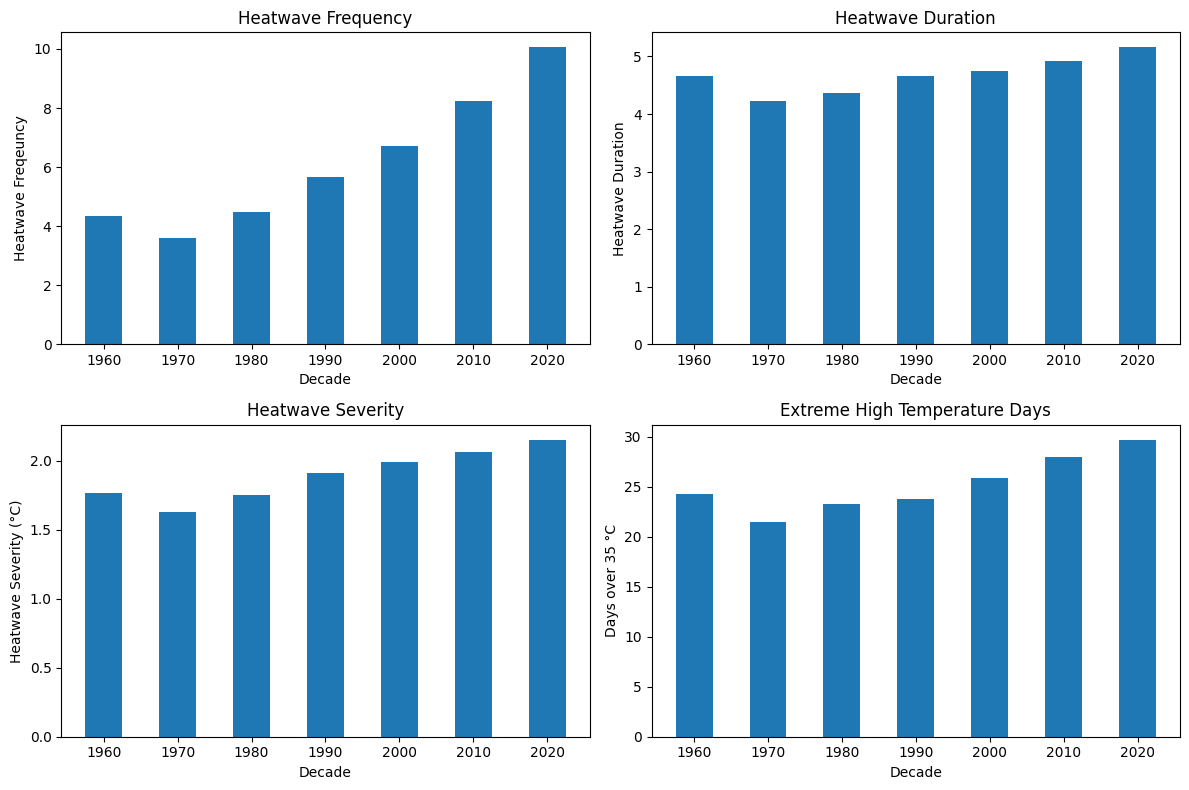

In [ ]:

# List of decades to process
decades = list(range(1960, 2024, 10))

# Initialize dictionaries to store the mean values for each variable by decade
mean_values = {
    'hw_count': [],
    'hw_days': [],
    'hw_temp_diff': [],
    'high_temp_degree_days': []
}

# List to keep track of valid decades
valid_decades = []

with rasterio.open('/content/drive/MyDrive/hwi_product/hwi_1960s/temp.vrt') as src:
    # Read the land mask
    land_mask = src.read(1)
    land_mask_nan = np.where(land_mask != 1, np.nan, 1)

# Process each decade
for start_year in decades:
    output_file = os.path.join(output_folder, f'average_hwi_{start_year}s.tif')
    if os.path.exists(output_file):
        with rasterio.open(output_file) as src:
            try:
                # Read each band (variable) and calculate the mean value
                hw_count = src.read(1) * land_mask_nan
                hw_days = src.read(2) * land_mask_nan
                hw_avg_days = hw_days/hw_count
                hw_temp_diff = src.read(3) * land_mask_nan
                high_temp_degree_days = src.read(4) * land_mask_nan

                mean_values['hw_count'].append(np.nanmean(hw_count))
                mean_values['hw_days'].append(np.nanmean(hw_avg_days))
                mean_values['hw_temp_diff'].append(np.nanmean(hw_temp_diff))
                mean_values['high_temp_degree_days'].append(np.nanmean(high_temp_degree_days))

                # Append the valid decade
                valid_decades.append(start_year)
            except Exception as e:
                print(f"Error processing file for {start_year}: {e}")

# Create the bar plots with thicker bars
bar_width = 5  # Adjust the width of the bars

plt.figure(figsize=(12, 8))

# Plot hw_count
plt.subplot(2, 2, 1)
plt.bar(valid_decades, mean_values['hw_count'], width=bar_width)
plt.title('Heatwave Frequency')
plt.xlabel('Decade')
plt.ylabel('Heatwave Freqeuncy')

# Plot hw_days
plt.subplot(2, 2, 2)
plt.bar(valid_decades, mean_values['hw_days'], width=bar_width)
plt.title('Heatwave Duration')
plt.xlabel('Decade')
plt.ylabel('Heatwave Duration')

# Plot hw_temp_diff
plt.subplot(2, 2, 3)
plt.bar(valid_decades, mean_values['hw_temp_diff'], width=bar_width)
plt.title('Heatwave Severity')
plt.xlabel('Decade')
plt.ylabel('Heatwave Severity (°C)')

# Plot high_temp_degree_days
plt.subplot(2, 2, 4)
plt.bar(valid_decades, mean_values['high_temp_degree_days'], width=bar_width)
plt.title('Extreme High Temperature Days')
plt.xlabel('Decade')
plt.ylabel('Days over 35 °C')

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.crs as ccrs

# Define the input files for the 1960s and 2020s
file_1960s = os.path.join(output_folder, 'average_hwi_1960s.tif')
file_2020s = os.path.join(output_folder, 'average_hwi_2020s.tif')

# Initialize dictionaries to hold data for the 1960s and 2020s
data_1960s = {}
data_2020s = {}

pop_vrt_path = '/content/drive/MyDrive/GPW4/pop.vrt'
with rasterio.open(pop_vrt_path) as pop_src:
    child_pop = pop_src.read(1)

scale_factor = 11.132

with rasterio.open('/content/drive/MyDrive/hwi_product/hwi_1960s/temp.vrt') as src:
    # Read the land mask
    land_mask = src.read(1)
    land_mask_nan = np.where(land_mask != 1, np.nan, 1)

# Function to read data from a file and store in the dictionary
def read_data(file_path, data_dict):
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data_dict['hw_count'] = src.read(1) * land_mask_nan
            data_dict['hw_days'] = src.read(2)/src.read(1) * land_mask_nan
            data_dict['hw_temp_diff'] = src.read(3) * land_mask_nan
            data_dict['high_temp_degree_days'] = src.read(4) * land_mask_nan

# Read data for the 1960s and 2020s
read_data(file_1960s, data_1960s)
read_data(file_2020s, data_2020s)

# Calculate the percentage increase for each indicator and handle invalid values
percentage_increase = {}
exposure50 = {}
exposure100 = {}
exposure200 = {}

for key in data_1960s.keys():
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_increase[key] = ((data_2020s[key] - data_1960s[key]) / data_1960s[key]) * 100
        percentage_increase[key] = np.ma.masked_invalid(percentage_increase[key])
        mask_high_percentage = percentage_increase[key] > 50
        exposure50[key] = np.nansum(child_pop[mask_high_percentage]) * scale_factor * scale_factor
        mask_high_percentage = percentage_increase[key] > 100
        exposure100[key] = np.nansum(child_pop[mask_high_percentage]) * scale_factor * scale_factor
        mask_high_percentage = percentage_increase[key] > 200
        exposure200[key] = np.nansum(child_pop[mask_high_percentage]) * scale_factor * scale_factor

# Define the categories for the increases with a range up to 200%
categories = {}
for key in percentage_increase.keys():
    categories[key] = np.zeros_like(percentage_increase[key], dtype=int)
    categories[key][(percentage_increase[key] >= 0) & (percentage_increase[key] < 50)] = 1
    categories[key][(percentage_increase[key] >= 50) & (percentage_increase[key] < 100)] = 2
    categories[key][(percentage_increase[key] >= 100) & (percentage_increase[key] < 150)] = 3
    categories[key][(percentage_increase[key] >= 150) & (percentage_increase[key] < 200)] = 4
    categories[key][percentage_increase[key] >= 200] = 5

# Define a more distinct colormap
cmap = ListedColormap(['white', '#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15'])
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = BoundaryNorm(bounds, cmap.N)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.Robinson()})
fig.suptitle('Percentage Increase in Heatwave Indicators (1960s to 2020s)')

indicators = ['hw_count', 'hw_days', 'hw_temp_diff', 'high_temp_degree_days']
titles = ['Heatwave Frequency', 'Heatwave Duration', 'Heatwave Severity', 'Extreme Temperature Days']

for ax, indicator, title in zip(axs.ravel(), indicators, titles):
    ax.set_global()
    ax.coastlines()
    im = ax.imshow(categories[indicator], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
                   extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
    ax.set_title(title)

# Add colorbar with correct labels
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', pad=0.02, shrink=0.6, aspect=30, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_xticklabels(['< 50%', '50% - 100%', '100% - 150%', '150% - 200%', '> 200%'])
cbar.set_label('Percentage Increase')

plt.show()

# Print the number of children exposed to >50% increase
for key in exposure50.keys():
    print(f"Number of children exposed to >50% increase in {key.replace('_', ' ')}: {exposure50[key]:,.0f}")


In [ ]:
for key in exposure100.keys():
    print(f"Number of children exposed to >100% increase in {key.replace('_', ' ')}: {exposure100[key]:,.0f}")


In [ ]:
for key in exposure200.keys():
    print(f"Number of children exposed to >200% increase in {key.replace('_', ' ')}: {exposure200[key]:,.0f}")

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.crs as ccrs

# Define the input files for each decade
decades = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
data_files = {decade: os.path.join(output_folder, f'average_hwi_{decade}.tif') for decade in decades}

# Initialize dictionary to hold data for each decade
data_decades = {decade: {} for decade in decades}

pop_vrt_path = '/content/drive/MyDrive/GPW4/pop.vrt'
with rasterio.open(pop_vrt_path) as pop_src:
    child_pop = pop_src.read(1)

scale_factor = 11.132

with rasterio.open('/content/drive/MyDrive/hwi_product/hwi_1960s/temp.vrt') as src:
    # Read the land mask
    land_mask = src.read(1)
    land_mask_nan = np.where(land_mask != 1, np.nan, 1)

# Function to read data from a file and store in the dictionary
def read_data(file_path, data_dict):
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data_dict['hw_count'] = src.read(1) * land_mask_nan
            data_dict['hw_days'] = src.read(2)/src.read(1) * land_mask_nan
            data_dict['hw_temp_diff'] = src.read(3) * land_mask_nan
            data_dict['high_temp_degree_days'] = src.read(4) * land_mask_nan

# Read data for each decade
for decade in decades:
    read_data(data_files[decade], data_decades[decade])

# Combine data for all decades to calculate overall mean and standard deviation
combined_data = {indicator: [] for indicator in data_decades['1960s'].keys()}
for decade in decades:
    for indicator in combined_data.keys():
        combined_data[indicator].append(data_decades[decade][indicator])

# Calculate global mean and standard deviation across all decades and spatial dimensions
mean_values = {indicator: np.nanmean(np.stack(combined_data[indicator]), axis=(0, 1, 2)) for indicator in combined_data.keys()}
std_dev = {indicator: np.nanstd(np.stack(combined_data[indicator]), axis=(0, 1, 2)) for indicator in combined_data.keys()}



In [ ]:
# Identify areas where indicators are higher than 1, 2, and 3 standard deviations for the target year
target_decade = '1970s'
categories = {indicator: np.zeros_like(data_decades[target_decade][indicator]) for indicator in combined_data.keys()}

exposure_2std = {}
for indicator in mean_values.keys():
    data = data_decades[target_decade][indicator]
    categories[indicator][np.where(data > mean_values[indicator] + 3 * std_dev[indicator])] = 3
    categories[indicator][np.where((data > mean_values[indicator] + 2 * std_dev[indicator]) & (data <= mean_values[indicator] + 3 * std_dev[indicator]))] = 2
    categories[indicator][np.where((data > mean_values[indicator] + std_dev[indicator]) & (data <= mean_values[indicator] + 2 * std_dev[indicator]))] = 1
    mask_high_percentage = np.where(data > mean_values[indicator] + 2 * std_dev[indicator])
    exposure_2std[indicator] = np.nansum(child_pop[mask_high_percentage]) * scale_factor * scale_factor

# Plotting the target year separately in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.Robinson()})
fig.suptitle(f'Indicators Exceeding Standard Deviations ({target_decade})')

indicators = ['hw_count', 'hw_days', 'hw_temp_diff', 'high_temp_degree_days']
titles = ['Heatwave Frequency', 'Heatwave Duration', 'Heatwave Severity', 'Extreme Temperature Days']

# Define a more distinct colormap
cmap = ListedColormap(['white', 'yellow', 'orange', 'red'])
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, cmap.N)

for ax, indicator, title in zip(axs.ravel(), indicators, titles):
    ax.set_global()
    ax.coastlines()
    im = ax.imshow(categories[indicator], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
                   extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
    ax.set_title(title)

# Add colorbar with correct labels, positioned correctly
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=[1, 2, 3])
cbar.ax.set_xticklabels(['> 1 STD', '> 2 STD', '> 3 STD'])
cbar.set_label('Standard Deviations')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

In [ ]:
# Print the number of children exposed to >50% increase
for key in exposure_2std.keys():
    print(f"Number of children exposed to >2 Standard Deviation in {key.replace('_', ' ')}: {exposure_2std[key]:,.0f}")
